In [1]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
#using Reel
using SparseArrays
using GridInterpolations
using DataStructures
using DataFrames
using CSV
using Distributed

In [2]:

include("atan2.jl")
include("obs_rel.jl")
include("polargrid_rel_qual2.jl")
rng = MersenneTwister(2);
#

In [3]:
# random walk

POS_0 = [6.0, 60.0]
CRS_0 = 90 # target's course
SPD_0 = 1 # 1 or 2
TGT_SPD = 1

#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crsIOL:>
    end
    crs = (crs + rand(rng,[-1,1])*30) % 360
    if crs < 0 crs += 360 end
    return crs
end

# state as tuple (x, y, crs, spd) of target (spd of o/s)
function f(state, control, rng)
    r, θ, crs, spd = state
    θ += control[1]
    spd = control[2]
    if θ < 0 θ += 360 end
    θ = θ % 360
    crs -= control[1]
    if crs < 0 crs += 360 end
    crs = crs % 360
    x = r*cos(π/180*θ)
    y = r*sin(π/180*θ)
    pos = [x + TGT_SPD*cos(π/180*crs) - spd, y + 
        TGT_SPD*sin(π/180*crs)]
    crs = next_crs(crs,rng)
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    if θ < 0 θ += 360 end
    return (r, θ, crs, spd)::NTuple{4, Real}
end
#

f (generic function with 1 method)

In [4]:
function r(s)
    range = s[1]
    if range > 150 return -.2 end  # reward to not lose track of contact
    if range <= 10 return -10 end  # collision avoidance
    return .1  # being in "sweet spot" maximizes reward
end
#

r (generic function with 1 method)

In [5]:
#angles = [0, 30, 60, 90, 120, 150, 210, 240, 270, 300, 330]

statespace = thestates
actionspace = ((30,1), (0,1), (-30,1), (30, 2), (0,2), (-30,2))

action_index(a) = trunc(Int, 2*(a[1]/30+1) + a[2])
actions_ = ((-30,1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))



((-30, 1), (-30, 2), (0, 1), (0, 2), (30, 1), (30, 2))

In [6]:
# returns vector rather than Tuple, for particle filter
function f2(x, u, rng)
    temp = [i for i in f(x, u, rng)]
    return temp
end

f2 (generic function with 1 method)

In [7]:
totals = [0.0]
#θ = zeros(length(grid),6);
e = sparse(zeros(length(grid),6))
θ = [r(Tuple(ind2x(grid, j))) for j in 1:length(grid), i in 1:6];

In [9]:

N = 500
model = ParticleFilterModel{Vector{Float64}}(f2, g)
pfilter = SIRParticleFilter(model, N);
α = 0.3
γ = 0.9
ϵ = 0.75
x = [20, 60, 90, 1, 1];
λ = 0.9
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
counter = 0


0

In [ ]:
## Q-learning loop
#plots = []
#betas = Deque{Array}()
#β = zeros(length(grid),6);
# this is realistically the best performer


epochs = 5000
epochsize = 500

total = 0
rando = 0

k = 15
last = 0
x = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, 1, 1];     
b = ParticleCollection([x[1:4] for i in 1:N]);     
ξ = sparse(weighted_grid_2(b)/N)
uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
rando += uu[2]
u = uu[1]

for i in 1:(epochsize*epochs)
    counter += 1
    
    e[:,u] += ξ
    last = transpose(θ[:,u])*ξ
    
    # choose next action
    uu = next_action([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], ϵ, rng)
    u = uu[1]
    rando += uu[2]
    a_star = uu[3]
    
    #observe new state and reward
    xp = f2(x, actions_[u], rng)
    y = h(xp, rng)
    b = update(pfilter, b, actions_[u], y)
    rew = r(Tuple(xp))
       
    ξ = sparse(weighted_grid_2(b)/N)
     
    total += rew
        
    #cur = (rew + γ * max2([transpose(θ[:,j])*ξ for j in 1:size(θ)[2]], rng))
    
    #argmax state-action pair, not realized state-action pair?
    cur = transpose(θ[:,a_star])*ξ
    
    δ = rew + γ * cur - last
    
    θ += α * δ * e
    if uu[2] == 0
        e *= γ * λ
    else
        e = sparse(zeros(length(grid),6))
    end
    
        
    if counter % epochsize == 0
        push!(totals, total*500/epochsize)
        println("--------- CURRENT: ", round(total*500/epochsize, sigdigits=4), " AVG: ", round(mean(totals), sigdigits=4), " Epoch: ", 
            trunc(Int, counter/epochsize), " -----------")
        total = 0
        rando = 0
        xp = [rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2]), 1];
        b = ParticleCollection([[rand(rng, 25:150), rand(rng,0:359), rand(rng,0:11)*30, rand(rng, [1,2])] for i in 1:N]);
        ξ = sparse(weighted_grid_2(b)/N)
        running_avg = mean(totals)
        ϵ = max(.75-counter/480000, .1)
    end
    if counter % (epochsize*5) == 0
        thetaframe = DataFrame(θ)
        CSV.write("current482.csv", thetaframe)
    end
    
    x = xp
    
    
    #plotting
    #r_ = [row[1] for row in particles(b)]
    #theta = [row[2] for row in particles(b)]*π/180
    #x_theta = x[2]*π/180
    #x_r = x[1 ]
    
    #print(".")
    #plt = plot(proj=:polar, lims=(0,200), size=(1000,1000))
    #scatter!(theta, r_, markersize=1, label="particles")
    #scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #push!(plots, plt)
    
end


--------- CURRENT: 43.0 AVG: 35.82 Epoch: 11 -----------
--------- CURRENT: 50.0 AVG: 36.91 Epoch: 12 -----------
--------- CURRENT: -40.9 AVG: 31.35 Epoch: 13 -----------
--------- CURRENT: 17.6 AVG: 30.43 Epoch: 14 -----------
--------- CURRENT: 14.0 AVG: 29.41 Epoch: 15 -----------
--------- CURRENT: 50.0 AVG: 30.62 Epoch: 16 -----------
--------- CURRENT: 50.0 AVG: 31.69 Epoch: 17 -----------
--------- CURRENT: 50.0 AVG: 32.66 Epoch: 18 -----------
--------- CURRENT: 50.0 AVG: 33.53 Epoch: 19 -----------
--------- CURRENT: -222.7 AVG: 21.32 Epoch: 20 -----------
--------- CURRENT: 50.0 AVG: 22.63 Epoch: 21 -----------
--------- CURRENT: -182.3 AVG: 13.72 Epoch: 22 -----------
--------- CURRENT: 50.0 AVG: 15.23 Epoch: 23 -----------
--------- CURRENT: 19.7 AVG: 15.41 Epoch: 24 -----------
--------- CURRENT: 40.7 AVG: 16.38 Epoch: 25 -----------
--------- CURRENT: 50.0 AVG: 17.63 Epoch: 26 -----------
--------- CURRENT: 50.0 AVG: 18.78 Epoch: 27 -----------
--------- CURRENT: 50.0 AV

--------- CURRENT: 40.4 AVG: 15.16 Epoch: 163 -----------
--------- CURRENT: -20.7 AVG: 14.95 Epoch: 164 -----------
--------- CURRENT: 46.4 AVG: 15.14 Epoch: 165 -----------
--------- CURRENT: 50.0 AVG: 15.34 Epoch: 166 -----------
--------- CURRENT: -40.9 AVG: 15.01 Epoch: 167 -----------
--------- CURRENT: 50.0 AVG: 15.22 Epoch: 168 -----------
--------- CURRENT: 50.0 AVG: 15.42 Epoch: 169 -----------
--------- CURRENT: 50.0 AVG: 15.62 Epoch: 170 -----------
--------- CURRENT: 50.0 AVG: 15.82 Epoch: 171 -----------
--------- CURRENT: 23.3 AVG: 15.87 Epoch: 172 -----------
--------- CURRENT: 50.0 AVG: 16.06 Epoch: 173 -----------
--------- CURRENT: 50.0 AVG: 16.26 Epoch: 174 -----------
--------- CURRENT: 50.0 AVG: 16.45 Epoch: 175 -----------
--------- CURRENT: 39.9 AVG: 16.58 Epoch: 176 -----------
--------- CURRENT: 43.1 AVG: 16.73 Epoch: 177 -----------
--------- CURRENT: 50.0 AVG: 16.92 Epoch: 178 -----------
--------- CURRENT: 50.0 AVG: 17.1 Epoch: 179 -----------
--------- CUR

--------- CURRENT: 43.7 AVG: 19.47 Epoch: 304 -----------
--------- CURRENT: 13.1 AVG: 19.45 Epoch: 305 -----------
--------- CURRENT: 50.0 AVG: 19.55 Epoch: 306 -----------
--------- CURRENT: 50.0 AVG: 19.65 Epoch: 307 -----------
--------- CURRENT: 50.0 AVG: 19.74 Epoch: 308 -----------
--------- CURRENT: 50.0 AVG: 19.84 Epoch: 309 -----------
--------- CURRENT: 46.1 AVG: 19.93 Epoch: 310 -----------
--------- CURRENT: 50.0 AVG: 20.02 Epoch: 311 -----------
--------- CURRENT: 50.0 AVG: 20.12 Epoch: 312 -----------
--------- CURRENT: -91.4 AVG: 19.76 Epoch: 313 -----------
--------- CURRENT: 19.7 AVG: 19.76 Epoch: 314 -----------
--------- CURRENT: 50.0 AVG: 19.86 Epoch: 315 -----------
--------- CURRENT: 50.0 AVG: 19.95 Epoch: 316 -----------
--------- CURRENT: 9.6 AVG: 19.92 Epoch: 317 -----------
--------- CURRENT: 50.0 AVG: 20.02 Epoch: 318 -----------
--------- CURRENT: 50.0 AVG: 20.11 Epoch: 319 -----------
--------- CURRENT: 50.0 AVG: 20.2 Epoch: 320 -----------
--------- CURRE

--------- CURRENT: -111.6 AVG: 23.73 Epoch: 445 -----------
--------- CURRENT: 50.0 AVG: 23.79 Epoch: 446 -----------
--------- CURRENT: -64.6 AVG: 23.6 Epoch: 447 -----------
--------- CURRENT: 50.0 AVG: 23.65 Epoch: 448 -----------
--------- CURRENT: 50.0 AVG: 23.71 Epoch: 449 -----------
--------- CURRENT: 50.0 AVG: 23.77 Epoch: 450 -----------
--------- CURRENT: 47.3 AVG: 23.82 Epoch: 451 -----------
--------- CURRENT: 50.0 AVG: 23.88 Epoch: 452 -----------
--------- CURRENT: 37.1 AVG: 23.91 Epoch: 453 -----------
--------- CURRENT: -51.0 AVG: 23.75 Epoch: 454 -----------
--------- CURRENT: 50.0 AVG: 23.8 Epoch: 455 -----------
--------- CURRENT: 50.0 AVG: 23.86 Epoch: 456 -----------
--------- CURRENT: 50.0 AVG: 23.92 Epoch: 457 -----------
--------- CURRENT: 50.0 AVG: 23.97 Epoch: 458 -----------
--------- CURRENT: 50.0 AVG: 24.03 Epoch: 459 -----------
--------- CURRENT: 50.0 AVG: 24.09 Epoch: 460 -----------
--------- CURRENT: 47.3 AVG: 24.14 Epoch: 461 -----------
--------- CU

--------- CURRENT: 15.2 AVG: 27.0 Epoch: 587 -----------
--------- CURRENT: 50.0 AVG: 27.04 Epoch: 588 -----------
--------- CURRENT: 50.0 AVG: 27.08 Epoch: 589 -----------
--------- CURRENT: 50.0 AVG: 27.12 Epoch: 590 -----------
--------- CURRENT: 50.0 AVG: 27.16 Epoch: 591 -----------
--------- CURRENT: 50.0 AVG: 27.19 Epoch: 592 -----------
--------- CURRENT: 50.0 AVG: 27.23 Epoch: 593 -----------
--------- CURRENT: 50.0 AVG: 27.27 Epoch: 594 -----------
--------- CURRENT: 42.2 AVG: 27.3 Epoch: 595 -----------
--------- CURRENT: 33.8 AVG: 27.31 Epoch: 596 -----------
--------- CURRENT: 50.0 AVG: 27.34 Epoch: 597 -----------
--------- CURRENT: 41.3 AVG: 27.37 Epoch: 598 -----------
--------- CURRENT: 50.0 AVG: 27.41 Epoch: 599 -----------
--------- CURRENT: 50.0 AVG: 27.44 Epoch: 600 -----------
--------- CURRENT: 26.6 AVG: 27.44 Epoch: 601 -----------
--------- CURRENT: 50.0 AVG: 27.48 Epoch: 602 -----------
--------- CURRENT: 45.5 AVG: 27.51 Epoch: 603 -----------
--------- CURREN

--------- CURRENT: 50.0 AVG: 28.31 Epoch: 729 -----------
--------- CURRENT: 48.5 AVG: 28.33 Epoch: 730 -----------
--------- CURRENT: -20.7 AVG: 28.27 Epoch: 731 -----------
--------- CURRENT: 47.0 AVG: 28.29 Epoch: 732 -----------
--------- CURRENT: 44.6 AVG: 28.31 Epoch: 733 -----------
--------- CURRENT: 46.4 AVG: 28.34 Epoch: 734 -----------
--------- CURRENT: 25.7 AVG: 28.33 Epoch: 735 -----------
--------- CURRENT: 48.2 AVG: 28.36 Epoch: 736 -----------
--------- CURRENT: 48.5 AVG: 28.39 Epoch: 737 -----------
--------- CURRENT: 50.0 AVG: 28.42 Epoch: 738 -----------
--------- CURRENT: 50.0 AVG: 28.45 Epoch: 739 -----------
--------- CURRENT: 50.0 AVG: 28.48 Epoch: 740 -----------
--------- CURRENT: 50.0 AVG: 28.51 Epoch: 741 -----------
--------- CURRENT: 50.0 AVG: 28.53 Epoch: 742 -----------
--------- CURRENT: 48.2 AVG: 28.56 Epoch: 743 -----------
--------- CURRENT: 25.7 AVG: 28.56 Epoch: 744 -----------
--------- CURRENT: -0.7 AVG: 28.52 Epoch: 745 -----------
--------- CUR

In [54]:
θ = convert(Matrix, CSV.read("current472.csv"))

30420×6 Array{Float64,2}:
 -4.06072   0.0         -12.7153    0.0           -5.40007   0.0        
 -5.74517   0.0         -15.7834    0.0           -8.13179   0.0        
 -3.42704   0.0         -19.1464    0.0341359    -11.5613    0.0        
 -1.51409   0.0         -23.0423    0.0183138     -9.30633   0.0        
 -0.193465  0.0157158    -1.28939   0.00300404     1.32795   0.0        
  0.565902  0.00673533    0.684805  0.0            0.686657  0.0        
  0.808509  0.0           2.81592   0.00685856     0.59149   0.0        
  1.29874   0.0247135     1.06388   0.000762062    0.405348  0.000318762
  3.98132   0.0255353     0.240398  0.0            0.411339  0.0040335  
  5.7998    0.00871109    0.425003  0.0            0.405973  0.000776428
  4.92557   0.018768      0.61746   0.0            0.590034  0.0        
  5.92907   0.0385562     0.547618  0.0            0.593071  0.0        
  5.24864   0.00124996    0.443488  0.0            0.594687  0.0        
  ⋮                      

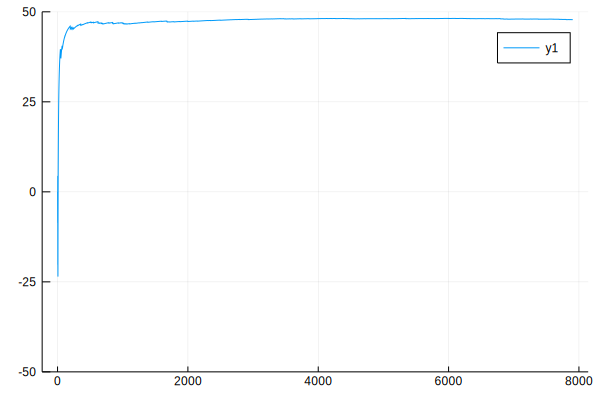

In [62]:
xx = []
yy = []
yyy = []
for (i, t) in enumerate(totals)
    push!(xx, i)
    push!(yy, t)
    push!(yyy, mean(yy))
end

plot(xx, yyy, ylims = (-50,50))

In [11]:
#thetaframe = CSV.read("0.44_theta_12.1_1.csv");


In [12]:
#θ = convert(Matrix, thetaframe)

In [57]:
thetaframe = DataFrame(θ)
CSV.write("0.470_baseline_final.csv", thetaframe)

"0.470_theta_2.3_1_excellent.csv"

In [51]:
b = ParticleCollection([[20, 60, 90, 1] for i in 1:N]);
ξ = weighted_grid_2(b)/N
var(ξ)


3.5612535612535624e-5